In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn import metrics

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time

%load_ext autoreload
%autoreload 2

In [2]:
def plot_learner(train_sizes, train_scores, test_scores, label_train,label_test, title, xlabel, ylabel, filename):
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label=label_train)
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label=label_test)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid()
    plt.savefig(filename)
    plt.show()

In [3]:
def import_data():
    df_ds1 = pd.read_csv("winequality-red.csv", sep=";").append(pd.read_csv("winequality-white.csv", sep=";"))
    #df_ds2 = pd.read_csv("dataset_37_diabetes.csv", sep=",")
    missing_values = ['?']
    df_ds2 = pd.read_csv("breast-cancer-wisconsin.csv", sep=",",na_values = missing_values)
    df_ds2.fillna(method='ffill',inplace=True)
    X_ds1 = np.array(df_ds1.values[:,1:-1])
    y_ds1 = np.array(df_ds1.values[:,-1])
    y_ds1 = (y_ds1<7).astype(int)
    X_ds2 = np.array(df_ds2.values[:,1:-1])
    y_ds2 = np.array(df_ds2.values[:,-1])
    #y_ds2 = (-1 * (y_ds2 == 'tested_negative') + 1  * (y_ds2 == 'tested_positive'))
    return X_ds1, y_ds1, X_ds2, y_ds2

In [4]:
def train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y), test_size=0.25)
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [5]:
X_ds1, y_ds1, X_ds2, y_ds2 = import_data()

In [6]:
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

In [7]:
def boost_learner(X_train, X_test, y_train, y_test):
    dt_ = tree.DecisionTreeClassifier(max_depth=7,random_state=18)
    __clf_boosted = AdaBoostClassifier(base_estimator=dt_, n_estimators= 200, random_state=18)
    print(__clf_boosted)
    t0 = time.time()
    __clf_boosted.fit(X_train,y_train)
    t1 = time.time() - t0
    print("Boosting - Training Time: ", t1)
    y_pred = __clf_boosted.predict(X_test)
    print('Boosting - Accuracy: ' , (metrics.accuracy_score(y_test, y_pred) * 100))
    #print('Boosting - Accuracy: ', clf_boosted.score(X_test, y_test) * 100)
    return __clf_boosted

In [8]:
def plot_boost_validation_curve(clf_boosted,X_train, y_train,filename):
    n_estimators_range = np.linspace(1,400,10).astype('int')
    train_scores, test_scores = validation_curve(clf_boosted, X_train, y_train, param_name="n_estimators", param_range=n_estimators_range, cv=5)
    plot_learner(n_estimators_range,train_scores, test_scores,'Training score', 'Cross-validation score','Validation Curve for Boosting', 'Numner of Estimators',  'Score', filename)


In [9]:
def set_boost_hyperparameters(clf_boosted, X_train, y_train,X_test):
    _params = [{'n_estimators' : np.linspace(1,40,10).astype('int')}]
    clf_boosted = GridSearchCV(clf_boosted, param_grid=_params, cv=10)
    clf_boosted.fit(X_train, y_train)
    clf_boosted_ = clf_boosted
    
    print('Boosting - Best Paremeters: ', clf_boosted_.best_params_)
    y_pred = clf_boosted_.predict(X_test)
    print('Boosting - Accuracy: ',metrics.accuracy_score(y_test, y_pred) * 100)
    return clf_boosted_.best_params_

In [10]:
def plot_boost_learning_curve(clf_boosted_param,  X_train, y_train,filename):
    n_estimators = clf_boosted_param['n_estimators']
    dt_best = tree.DecisionTreeClassifier(max_depth=7,random_state=18)
    __clf__lc_boosted = AdaBoostClassifier(base_estimator=dt_best, n_estimators= 2, random_state=18)
    print(__clf__lc_boosted)
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(__clf__lc_boosted, X_train, y_train, train_sizes=train_sizes, cv=5, random_state=18)
    plot_learner(train_sizes,train_scores, test_scores,'Training score', 'Cross-validation score','Learning Curve for Boosting', 'Training Examples',  'Score', filename)


In [11]:
X_train, X_test, y_train, y_test = train_test(X_ds1, y_ds1)

In [12]:
clf_boosted_1 = boost_learner(X_train, X_test, y_train, y_test)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=7,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=18,
                               

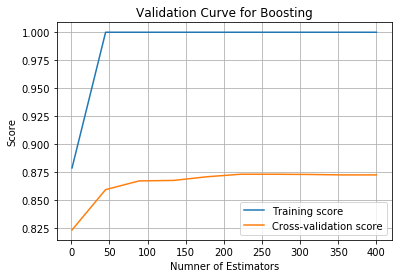

In [13]:
plot_boost_validation_curve(clf_boosted_1,X_train, y_train,'boosting_validation_curve_1-100.png')

In [14]:
clf_boosted_best_param = set_boost_hyperparameters(clf_boosted_1, X_train, y_train,X_test)

Boosting - Best Paremeters:  {'n_estimators': 27}
Boosting - Accuracy:  86.33846153846154


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=7,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=18,
                               

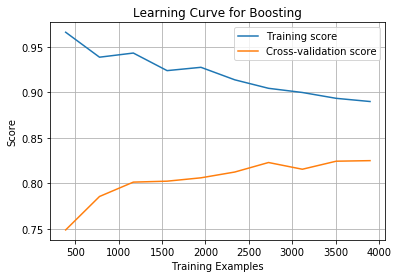

In [15]:
plot_boost_learning_curve(clf_boosted_best_param,  X_train, y_train,'boosting_learning_curve_1-100.png')

In [16]:
X_train, X_test, y_train, y_test = train_test(X_ds2, y_ds2)

In [17]:
clf_boosted_2 = boost_learner(X_train, X_test, y_train, y_test)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=7,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=18,
                               

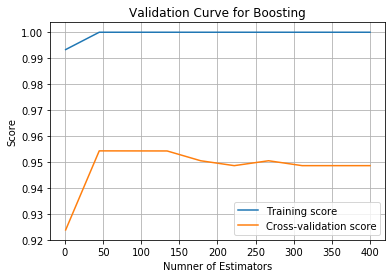

In [18]:
plot_boost_validation_curve(clf_boosted_2,X_train, y_train,'boosting_validation_curve_2-100.png')

In [19]:
clf_boosted_best_2 = set_boost_hyperparameters(clf_boosted_2, X_train, y_train,X_test)

Boosting - Best Paremeters:  {'n_estimators': 14}
Boosting - Accuracy:  98.28571428571429


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=7,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=18,
                               

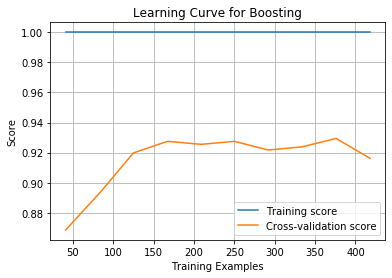

In [20]:
plot_boost_learning_curve(clf_boosted_best_2,  X_train, y_train,'boosting_learning_curve_2-100.png')